# Visual and Data Analysis - FIFA 19 Players
- **Created by Andrés Segura Tinoco**
- **Created on May 20, 2019**

# 5. Analysis of Similarity
## Loading main libraries and data

In [1]:
# Load the Pandas libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from collections import OrderedDict

In [2]:
# Load Similarity libraries
from scipy import stats as ss
import sklearn.metrics.pairwise as sm

In [3]:
# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Read FIFA 19 players data only using the current skill values
dataURL = "https://raw.githubusercontent.com/ansegura7/DataScience_FIFA19Data/master/data/fifa19_overall_data.csv"
rawdata = pd.read_csv(dataURL)

In [5]:
# Function that obtains the numerical data from the data frame
def getNumericalData(data, quality):
    numData = pd.DataFrame()
    
    # Create DataFrame
    for col in data.columns:
        if (str(data[col].dtype) != "object"):
            numData[col] = data[col]
    
    # Remove columns that are not relevant for the analysis
    nonColumns = ["Order", "ID", "Overall", "Potential", "Value €", "Wage €", "Release Clause €"]
    numData = numData.drop(nonColumns, axis=1)
    
    # Data Quality process
    if(quality and len(numData.columns) > 0):
        numData = numData.fillna(numData.mean())
    
    print(numData.shape)
    return numData;

In [6]:
# Set a Overall threshold
threshold = 85
threshold

85

In [7]:
# Filter/Delete player with an overall below the threshold
rawdata = rawdata.loc[rawdata["Overall"] >= threshold]
len(rawdata)

110

In [8]:
# Get only numeric columns/variables
numData = getNumericalData(rawdata, True)
numData.head()

(110, 68)


,Age,Special,International Reputation,Weak Foot,Skill Moves,Jersey Number,HeightMts,WeightLbs,LS,ST,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,2202,5.0,4.0,4.0,10.0,1.70,159.0,88,88,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,2228,5.0,4.0,5.0,7.0,1.88,183.0,91,91,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,2143,5.0,5.0,5.0,10.0,1.75,150.0,84,84,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,1471,4.0,3.0,1.0,1.0,1.93,168.0,0,0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,2281,4.0,5.0,4.0,7.0,1.80,154.0,82,82,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


## Apply PCA with Standardization

In [9]:
# Function that apply Principal Component Analysis
def applyPCA(data, std):
    
    # Standardize the Data
    if std == True:
        x = StandardScaler().fit_transform(data.values)
    else:
        x = data.values
    
    # Create a DataFrame from PCA
    pca = PCA(n_components = 5)
    pcaData = pca.fit_transform(x)
    pcaDF = pd.DataFrame(data = pcaData, columns = ["PC1", "PC2", "PC3", "PC4", "PC5"])
    
    # Show the total explained variance ratio of model
    print(sum(pca.explained_variance_ratio_) * 100)
    
    return pcaDF;

In [10]:
# Apply the PCA algorithm
pcaDF = applyPCA(numData, True)

# Create the PCA data
pcaDF = pd.concat([pcaDF, rawdata[["Name"]]], axis = 1)
pcaDF = pcaDF[pcaDF["PC1"].notnull()]
pcaDF.head(10)

90.29064729125005


,PC1,PC2,PC3,PC4,PC5,Name
0,-4.593481,-5.478033,1.127111,1.252885,-2.286953,L. Messi
1,-4.080334,-3.406618,4.334073,-0.485612,-2.817897,Cristiano Ronaldo
2,-4.048185,-5.546171,0.505673,0.616553,-1.730906,Neymar Jr
3,17.658339,-2.364764,-0.405911,1.214861,-1.087192,De Gea
4,-4.982714,-1.635134,0.422099,1.768055,-0.096850,K. De Bruyne
5,-3.976332,-4.619820,0.033077,0.196805,-0.812913,E. Hazard
6,-4.938277,-1.234102,-1.675975,2.188508,-1.576703,L. Modrić
7,-3.226382,-1.905506,2.889849,0.854872,-1.617664,L. Suárez
8,-2.522402,3.734704,0.422654,-0.277002,-1.654164,Sergio Ramos
9,18.786267,-1.573208,-0.490691,-0.521749,-0.242004,J. Oblak


## Apply Similarity Functions

In [11]:
# Returns the similarity between 2 vectors
def getSimilarity(func, x, y):
    similarity = 0
    
    if func == 'cosine':
        result = sm.cosine_similarity([x], [y])
        similarity = float(result[0])
    
    elif func == 'pearson':
        corr, p_value = ss.pearsonr(x, y)
        similarity = corr
        
    elif func == 'euclidean':
        result = sm.euclidean_distances([x], [y])
        similarity = float(result[0])
    
    elif func == 'manhattan':
        result = sm.manhattan_distances([x], [y])
        similarity = float(result[0])
    
    return similarity;

In [12]:
# Get more N similar instances
def getMoreSimilarInstances(df, func, n, target):
    solution = dict()
    simList = dict()
    currVector = df[df['Name'] == target]
    
    if (currVector is not None) and (len(currVector) > 0):
        currVector = currVector.values[0, 0:5];

        for ix, row in df.iterrows():
            currName = row['Name']
            if currName != target:
                neighVector = [row['PC1'], row['PC2'], row['PC3'], row['PC4'], row['PC5']]
                similarity = getSimilarity(func, currVector, neighVector)
                simList[currName] = similarity
                
        # Sorting dictionary in ascending order based on values
        n = min(len(simList), n)
        if n > 0:
            simList = OrderedDict(sorted(simList.items(), key = lambda kv: kv[1], reverse = True))
            ix = 0
            for key, value in simList.items():
                if ix < n:
                    solution[key] = round(value, 4)
                    ix += 1
                else:
                    break
    
    return solution;

In [13]:
# Palette by positions dictionary
posPalette = dict()
posPalette["Neighbor"] = "#3366cc"
posPalette["Current"] = "#109618"

# Create scatter plot with players label
def plot2DSimilarPlayers(df, corr, target):
    fig, ax = plt.subplots(figsize = (10, 10))
    
    # Create temp data
    players = list(solution.keys())
    players.append(target)
    data = pcaDF[pcaDF['Name'].isin(players)].copy()
    data['Size'] = 1
    data['Type'] = 'Neighbor'
    data.loc[data.Name == target, 'Size'] = 2
    data.loc[data.Name == target, 'Type'] = 'Current'
    
    # Create 2D scatter plot
    plot = sns.scatterplot(ax = ax, data = data, x = "PC1", y = "PC2", hue = "Type", size = 'Size', palette = posPalette)
    
    # Add annotations one by one with a loop
    for ix, row in data.iterrows():
        lblName = row["Name"]
        if lblName != target:
            lblName += '\nR: ' + str(corr[lblName])
        plot.text(row["PC1"] + 0.02, row["PC2"] - 0.03, lblName
                  , horizontalalignment = "left", size = "medium", color = "black", weight = "normal")
    
    # Plot setup
    ax.set_xlabel("PC 1", fontsize = 12)
    ax.set_ylabel("PC 2", fontsize = 12)
    ax.set_title("Similar Players in the Plane", fontsize = 20)
    ax.legend(["Players"], fontsize = 10, loc = 'lower right', frameon = True)
    ax.grid()

In [14]:
# Analysis params
fSimilarity = 'cosine'
nNeighbors = 10

In [15]:
# Show the N players most similar to 'L. Messi' using cosine metric
target = 'L. Messi'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
Neymar Jr,0.9901
E. Hazard,0.9659
M. Reus,0.9656
S. Agüero,0.9361
A. Sánchez,0.9196
A. Griezmann,0.9007
T. Müller,0.8916
David Silva,0.8714
L. Suárez,0.8529
M. Salah,0.8484


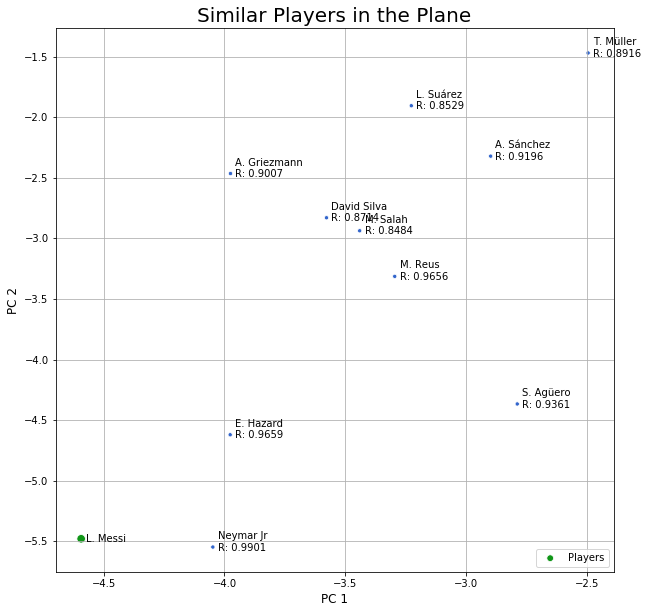

In [16]:
# Plot the N players most similar to 'L. Messi' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

In [17]:
# Show the N players most similar to 'L. Modrić' using cosine metric
target = 'L. Modrić'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
David Silva,0.9338
Iniesta,0.9076
K. De Bruyne,0.8990
Thiago,0.8915
M. Pjanić,0.8666
M. Verratti,0.8520
Marcelo,0.8486
Coutinho,0.8350
Koke,0.8302
J. Rodríguez,0.8073


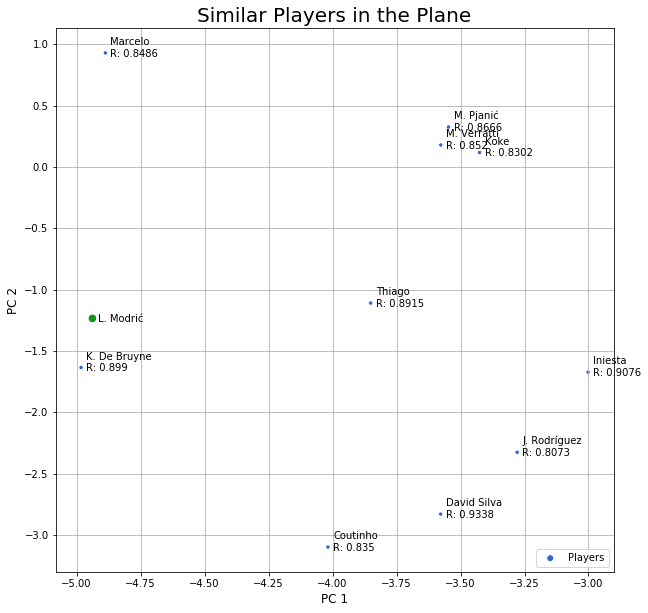

In [18]:
# Plot the N players most similar to 'L. Modrić' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

In [19]:
# Show the N players most similar to 'D. Godín' using cosine metric
target = 'D. Godín'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
G. Chiellini,0.9686
R. Varane,0.9663
M. Benatia,0.9628
Miranda,0.9621
V. van Dijk,0.9586
Pepe,0.9415
T. Alderweireld,0.9300
N. Otamendi,0.9225
J. Boateng,0.9140
L. Bonucci,0.9100


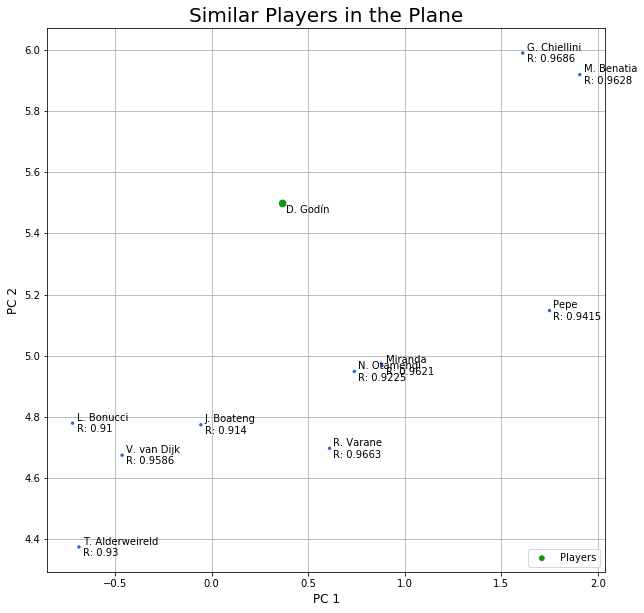

In [20]:
# Plot the N players most similar to 'D. Godín' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

In [21]:
# Show the N players most similar to 'De Gea' using cosine metric
target = 'De Gea'
solution = getMoreSimilarInstances(pcaDF, fSimilarity, nNeighbors, target)
pd.DataFrame.from_dict(solution, orient='index', columns=['Similarity'])

,Similarity
K. Navas,0.9971
T. Courtois,0.9943
G. Buffon,0.9938
J. Oblak,0.9931
H. Lloris,0.9925
W. Szczęsny,0.9917
S. Handanovič,0.9914
M. Neuer,0.9906
Alisson,0.9824
M. ter Stegen,0.9811


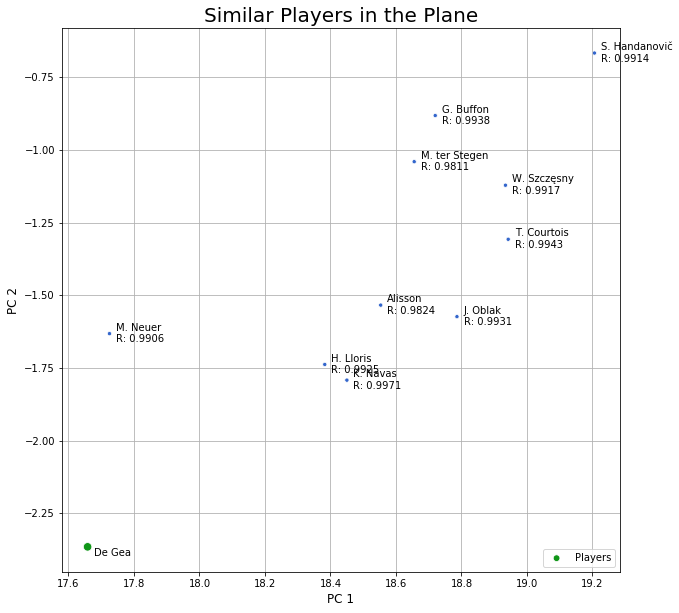

In [22]:
# Plot the N players most similar to 'De Gea' using cosine metric
plot2DSimilarPlayers(pcaDF, solution, target)

## Insights

- The N players most similar to a specific player can be calculated, using the similarity functions.
- The results are directly related to the similarity function used.

---
<a href="https://ansegura7.github.io/DataScience_FIFA19Data/">&laquo; Home</a>